In [100]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from collections import Counter

In [101]:
df=pd.read_csv("D:/Insurance_AI_project/datasets/generated_insurance_claims.csv")

In [102]:
df.head()

Claim_ID  Claim_Date  \
0  b884ddc0-5786-447c-9682-5e7d1d21d87b  2016-05-02   
1  722d397b-3a5c-4d92-95d8-3f9c301e08e5  2024-06-14   
2  68841882-21bb-4377-b9c7-df999f181c5d  2023-10-13   
3  5bb071ed-8d1f-41cf-8825-c35a3b04fe57  2023-12-24   
4  8c9fd3bf-16e6-40fa-a82b-e96551d82073  2023-09-28   

                            Customer_ID  Claim_Amount  Annual_Income  \
0  19403786-fd8f-4494-92b5-9a32b89e292f         38327          35708   
1  ba29f6bc-3a28-4c89-a6e0-dfc7203a6211          5916         116777   
2  01c63e10-85b3-4c98-8da7-d60049359c1d         20006         134926   
3  fcc85982-ffa0-4812-8a68-ec90ca32545d         23443          92565   
4  c6b84722-1780-4cb3-8b0d-89090922eb18         41402          92625   

  Claim_Type  Suspicious_Flags  Fraud_Label Policy_Issuance_Date  
0    Medical                 1            0           2009-08-17  
1       Home                 1            1           2024-02-28  
2       Life                 0            1           2017-07-23  
3       Auto                 1            1           2013-11-18  
4    Medical                 0            0           2022-06-02

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Claim_ID              500 non-null    object
 1   Claim_Date            500 non-null    object
 2   Customer_ID           500 non-null    object
 3   Claim_Amount          500 non-null    int64 
 4   Annual_Income         500 non-null    int64 
 5   Claim_Type            500 non-null    object
 6   Suspicious_Flags      500 non-null    int64 
 7   Fraud_Label           500 non-null    int64 
 8   Policy_Issuance_Date  500 non-null    object
dtypes: int64(4), object(5)
memory usage: 35.3+ KB


In [104]:
df.describe()

Claim_Amount  Annual_Income  Suspicious_Flags  Fraud_Label
count    500.000000      500.00000        500.000000   500.000000
mean   26106.594000    90577.71600          0.502000     0.524000
std    14144.183972    34725.81448          0.500497     0.499924
min     1053.000000    30712.00000          0.000000     0.000000
25%    14189.250000    61005.75000          0.000000     0.000000
50%    26697.500000    92187.50000          1.000000     1.000000
75%    38544.750000   118750.25000          1.000000     1.000000
max    49926.000000   149911.00000          1.000000     1.000000

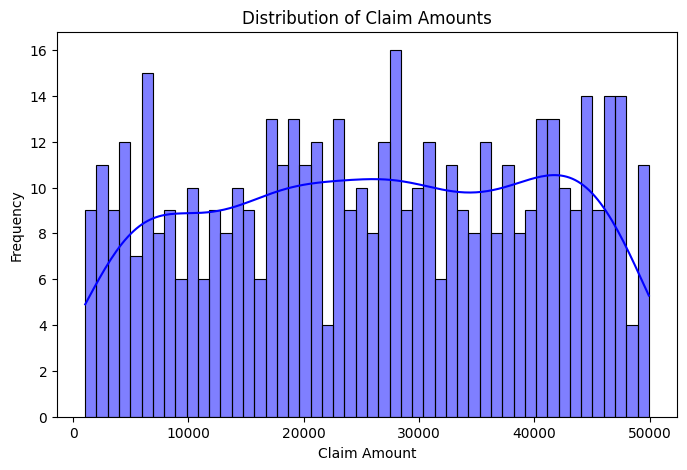

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df["Claim_Amount"], bins=50, kde=True, color="blue")
plt.title("Distribution of Claim Amounts")
plt.xlabel("Claim Amount")
plt.ylabel("Frequency")
plt.show()


C:\Users\naveen\AppData\Local\Temp\ipykernel_22264\4192937450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Fraud_Label"], y=df["Claim_Amount"], palette="coolwarm")


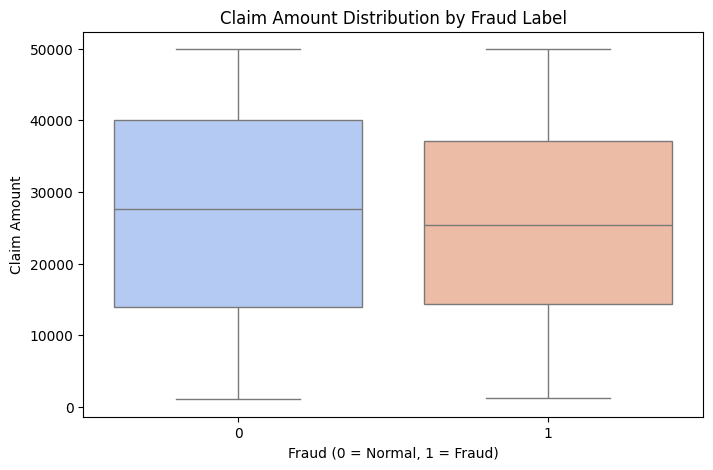

In [106]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Fraud_Label"], y=df["Claim_Amount"], palette="coolwarm")
plt.title("Claim Amount Distribution by Fraud Label")
plt.xlabel("Fraud (0 = Normal, 1 = Fraud)")
plt.ylabel("Claim Amount")
plt.show()


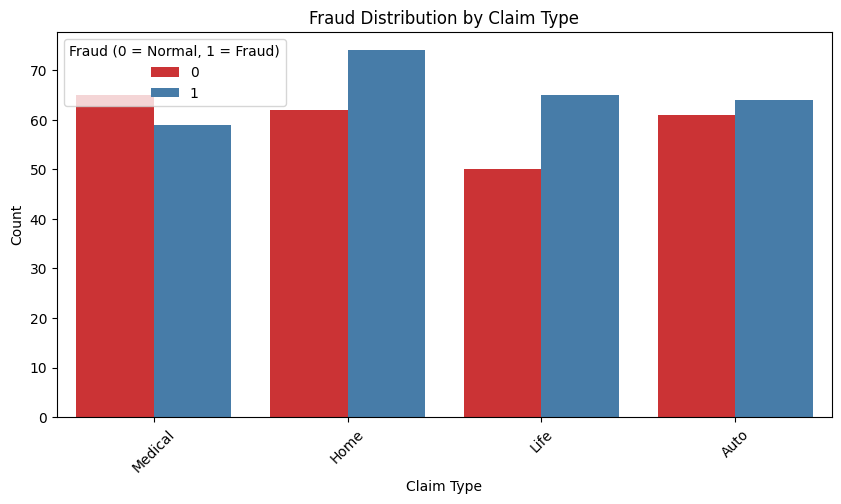

In [107]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Claim_Type", hue="Fraud_Label", data=df, palette="Set1")
plt.title("Fraud Distribution by Claim Type")
plt.xlabel("Claim Type")
plt.ylabel("Count")
plt.legend(title="Fraud (0 = Normal, 1 = Fraud)")
plt.xticks(rotation=45)
plt.show()


In [108]:
# ‚è≥ Convert Dates
df['Claim_Date'] = pd.to_datetime(df['Claim_Date'])
df['Policy_Issuance_Date'] = pd.to_datetime(df['Policy_Issuance_Date'])

In [109]:
# ‚úÖ Feature Engineering
df['Claim_to_Income_Ratio'] = df['Claim_Amount'] / df['Annual_Income']
df['Days_Since_Issuance'] = (df['Claim_Date'] - df['Policy_Issuance_Date']).dt.days


In [110]:
df.head()

Claim_ID Claim_Date  \
0  b884ddc0-5786-447c-9682-5e7d1d21d87b 2016-05-02   
1  722d397b-3a5c-4d92-95d8-3f9c301e08e5 2024-06-14   
2  68841882-21bb-4377-b9c7-df999f181c5d 2023-10-13   
3  5bb071ed-8d1f-41cf-8825-c35a3b04fe57 2023-12-24   
4  8c9fd3bf-16e6-40fa-a82b-e96551d82073 2023-09-28   

                            Customer_ID  Claim_Amount  Annual_Income  \
0  19403786-fd8f-4494-92b5-9a32b89e292f         38327          35708   
1  ba29f6bc-3a28-4c89-a6e0-dfc7203a6211          5916         116777   
2  01c63e10-85b3-4c98-8da7-d60049359c1d         20006         134926   
3  fcc85982-ffa0-4812-8a68-ec90ca32545d         23443          92565   
4  c6b84722-1780-4cb3-8b0d-89090922eb18         41402          92625   

  Claim_Type  Suspicious_Flags  Fraud_Label Policy_Issuance_Date  \
0    Medical                 1            0           2009-08-17   
1       Home                 1            1           2024-02-28   
2       Life                 0            1           2017-07-23   
3       Auto                 1            1           2013-11-18   
4    Medical                 0            0           2022-06-02   

   Claim_to_Income_Ratio  Days_Since_Issuance  
0               1.073345                 2450  
1               0.050661                  107  
2               0.148274                 2273  
3               0.253260                 3688  
4               0.446985                  483

In [111]:
# ‚úÖ One-Hot Encode 'Claim_Type'
df = pd.get_dummies(df, columns=['Claim_Type'], drop_first=False)

In [112]:
df.head()

Claim_ID Claim_Date  \
0  b884ddc0-5786-447c-9682-5e7d1d21d87b 2016-05-02   
1  722d397b-3a5c-4d92-95d8-3f9c301e08e5 2024-06-14   
2  68841882-21bb-4377-b9c7-df999f181c5d 2023-10-13   
3  5bb071ed-8d1f-41cf-8825-c35a3b04fe57 2023-12-24   
4  8c9fd3bf-16e6-40fa-a82b-e96551d82073 2023-09-28   

                            Customer_ID  Claim_Amount  Annual_Income  \
0  19403786-fd8f-4494-92b5-9a32b89e292f         38327          35708   
1  ba29f6bc-3a28-4c89-a6e0-dfc7203a6211          5916         116777   
2  01c63e10-85b3-4c98-8da7-d60049359c1d         20006         134926   
3  fcc85982-ffa0-4812-8a68-ec90ca32545d         23443          92565   
4  c6b84722-1780-4cb3-8b0d-89090922eb18         41402          92625   

   Suspicious_Flags  Fraud_Label Policy_Issuance_Date  Claim_to_Income_Ratio  \
0                 1            0           2009-08-17               1.073345   
1                 1            1           2024-02-28               0.050661   
2                 0            1           2017-07-23               0.148274   
3                 1            1           2013-11-18               0.253260   
4                 0            0           2022-06-02               0.446985   

   Days_Since_Issuance  Claim_Type_Auto  Claim_Type_Home  Claim_Type_Life  \
0                 2450            False            False            False   
1                  107            False             True            False   
2                 2273            False            False             True   
3                 3688             True            False            False   
4                  483            False            False            False   

   Claim_Type_Medical  
0                True  
1               False  
2               False  
3               False  
4                True

In [ ]:
#  Drop unnecessary columns
df = df.drop(columns=['Claim_ID', 'Customer_ID', 'Claim_Date', 'Policy_Issuance_Date'])

In [ ]:
#  Select features for anomaly detection
df_selected = df[['Claim_Amount', 'Annual_Income', 'Claim_to_Income_Ratio', 'Days_Since_Issuance']].copy()


In [ ]:
#  Anomaly Detection
elliptic = EllipticEnvelope(contamination=0.05)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

df["Elliptic_Outlier"] = elliptic.fit_predict(df_selected)
df["IsoForest_Outlier"] = iso_forest.fit_predict(df_selected)
df["LOF_Outlier"] = lof.fit_predict(df_selected)

# Convert to binary: 1 = Outlier, 0 = Normal
for col in ["Elliptic_Outlier", "IsoForest_Outlier", "LOF_Outlier"]:
    df[col] = df[col].apply(lambda x: 1 if x == -1 else 0)

# Combine anomaly signals
df["Anomaly_Flag"] = df[["Elliptic_Outlier", "IsoForest_Outlier", "LOF_Outlier"]].max(axis=1)
df["Anomaly_Score"] = df[["Elliptic_Outlier", "IsoForest_Outlier", "LOF_Outlier"]].sum(axis=1)


Elliptic Envelope works best for normal distributions but struggles with complex data shapes.

Isolation Forest is efficient with large datasets and works well in high-dimensional spaces.

LOF captures local anomalies that other methods might miss, especially when clusters have different densities.

By combining all three, you get more robust anomaly detection that works across various scenarios, ensuring fewer missed anomalies and better overall detection!

In [116]:
df.head()

Claim_Amount  Annual_Income  Suspicious_Flags  Fraud_Label  \
0         38327          35708                 1            0   
1          5916         116777                 1            1   
2         20006         134926                 0            1   
3         23443          92565                 1            1   
4         41402          92625                 0            0   

   Claim_to_Income_Ratio  Days_Since_Issuance  Claim_Type_Auto  \
0               1.073345                 2450            False   
1               0.050661                  107            False   
2               0.148274                 2273            False   
3               0.253260                 3688             True   
4               0.446985                  483            False   

   Claim_Type_Home  Claim_Type_Life  Claim_Type_Medical  Elliptic_Outlier  \
0            False            False                True                 1   
1             True            False               False                 0   
2            False             True               False                 0   
3            False            False               False                 0   
4            False            False                True                 0   

   IsoForest_Outlier  LOF_Outlier  Anomaly_Flag  Anomaly_Score  
0                  0            0             1              1  
1                  0            0             0              0  
2                  0            0             0              0  
3                  0            0             0              0  
4                  0            0             0              0

In [117]:
# üéØ Target and Features
y = df['Fraud_Label']
X = df.drop(columns=['Fraud_Label'])

In [118]:
# Ensure Anomaly_Score is included in X
X['Anomaly_Score'] = df['Anomaly_Score']

In [119]:
# üöÄ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [120]:
# ‚öñÔ∏è Scale Numerical Features for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [121]:
# üå≤ Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# üß† Train Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500,
                         random_state=42, early_stopping=True, validation_fraction=0.1)
nn_model.fit(X_train_scaled, y_train)
nn_probs = nn_model.predict_proba(X_test_scaled)[:, 1]


In [122]:
# üß™ Combine Scores (Ensemble)
df_test = X_test.copy()
df_test['RF_Score'] = rf_probs
df_test['NN_Score'] = nn_probs
df_test['Anomaly_Score'] = X_test['Anomaly_Score']
df_test['Fraud_Score'] = (df_test['RF_Score'] + df_test['NN_Score'] + df_test['Anomaly_Score']) / 3
df_test['Actual_Label'] = y_test
df_test['Predicted_Label'] = (df_test['Fraud_Score'] >= 0.5).astype(int)

In [123]:
# üßæ Metrics
auc = roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score'])
accuracy = accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label'])
f1 = f1_score(df_test['Actual_Label'], df_test['Predicted_Label'])
recall = recall_score(df_test['Actual_Label'], df_test['Predicted_Label'])

# üìä Results
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

AUC-ROC Score: 0.4996
Accuracy: 0.4500
F1 Score: 0.1270
Recall: 0.0769


In [124]:
print(df[['Anomaly_Score', 'Fraud_Label']].corr())


               Anomaly_Score  Fraud_Label
Anomaly_Score       1.000000     0.023078
Fraud_Label         0.023078     1.000000


In [129]:
df_test['Fraud_Score'] = (0.45 * df_test['RF_Score'] + 0.45 * df_test['NN_Score'] + 0.1 * df_test['Anomaly_Score'])


In [130]:
# Try a more conservative threshold
df_test['Predicted_Label'] = (df_test['Fraud_Score'] >= 0.5).astype(int)


In [131]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

# Evaluate updated metrics
accuracy = accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label'])
f1 = f1_score(df_test['Actual_Label'], df_test['Predicted_Label'])
recall = recall_score(df_test['Actual_Label'], df_test['Predicted_Label'])
auc = roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score'])

# Print results
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")


AUC-ROC Score: 0.4988
Accuracy: 0.4400
F1 Score: 0.3333
Recall: 0.2692


In [132]:
from sklearn.metrics import precision_score
precision = precision_score(df_test['Actual_Label'], df_test['Predicted_Label'])
print(f"Precision: {precision:.4f}")


Precision: 0.4375


In [133]:
from sklearn.metrics import precision_recall_curve

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(df_test['Actual_Label'], df_test['Fraud_Score'])

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Find best threshold
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

# Re-apply best threshold
df_test['Predicted_Label'] = (df_test['Fraud_Score'] >= best_threshold).astype(int)

# Recalculate final metrics
precision_final = precision_score(df_test['Actual_Label'], df_test['Predicted_Label'])
recall_final = recall_score(df_test['Actual_Label'], df_test['Predicted_Label'])
f1_final = f1_score(df_test['Actual_Label'], df_test['Predicted_Label'])
accuracy_final = accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label'])

print(f"Optimized Accuracy: {accuracy_final:.4f}")
print(f"Optimized Precision: {precision_final:.4f}")
print(f"Optimized Recall: {recall_final:.4f}")
print(f"Optimized F1 Score: {f1_final:.4f}")


Best Threshold: 0.34
Best F1 Score: 0.7042
Optimized Accuracy: 0.5800
Optimized Precision: 0.5556
Optimized Recall: 0.9615
Optimized F1 Score: 0.7042


In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ‚úÖ Apply Optimized Threshold
optimized_threshold = 0.34
df_test['Predicted_Label'] = (df_test['Fraud_Score'] >= optimized_threshold).astype(int)

# ‚úÖ Recalculate Evaluation Metrics
optimized_accuracy = accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label'])
optimized_precision = precision_score(df_test['Actual_Label'], df_test['Predicted_Label'])
optimized_recall = recall_score(df_test['Actual_Label'], df_test['Predicted_Label'])
optimized_f1 = f1_score(df_test['Actual_Label'], df_test['Predicted_Label'])
optimized_auc = roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score'])

# ‚úÖ Print Results
print(f"AUC-ROC Score: {optimized_auc:.4f}")
print(f"Optimized Accuracy: {optimized_accuracy:.4f}")
print(f"Optimized Precision: {optimized_precision:.4f}")
print(f"Optimized Recall: {optimized_recall:.4f}")
print(f"Optimized F1 Score: {optimized_f1:.4f}")


AUC-ROC Score: 0.4988
Optimized Accuracy: 0.5700
Optimized Precision: 0.5495
Optimized Recall: 0.9615
Optimized F1 Score: 0.6993


In [135]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# 1. Train XGBoost Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# 2. Predict probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. Ensemble Fraud Score (same weighting as before or update)
df_test['XGB_Score'] = xgb_probs
df_test['Fraud_Score_XGB'] = (0.45 * xgb_probs + 0.45 * df_test['NN_Score'] + 0.1 * df_test['Anomaly_Score'])

# 4. Optimize threshold using precision-recall
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(df_test['Actual_Label'], df_test['Fraud_Score_XGB'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

df_test['Predicted_Label_XGB'] = (df_test['Fraud_Score_XGB'] >= best_threshold).astype(int)

# 5. Final metrics
print("üìä XGBoost Model Metrics (Ensemble):")
print("AUC-ROC Score:", roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score_XGB']))
print("Optimized Accuracy:", accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label_XGB']))
print("Optimized Precision:", precision_score(df_test['Actual_Label'], df_test['Predicted_Label_XGB']))
print("Optimized Recall:", recall_score(df_test['Actual_Label'], df_test['Predicted_Label_XGB']))
print("Optimized F1 Score:", f1_score(df_test['Actual_Label'], df_test['Predicted_Label_XGB']))


üìä XGBoost Model Metrics (Ensemble):
AUC-ROC Score: 0.5336538461538461
Optimized Accuracy: 0.58
Optimized Precision: 0.5581395348837209
Optimized Recall: 0.9230769230769231
Optimized F1 Score: 0.6956521739130435


d:\Insurance_AI_project\myenvv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [136]:
import lightgbm as lgb

# 1. Train LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# 2. Predict probabilities
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# 3. Ensemble Fraud Score
df_test['LGBM_Score'] = lgb_probs
df_test['Fraud_Score_LGBM'] = (0.45 * lgb_probs + 0.45 * df_test['NN_Score'] + 0.1 * df_test['Anomaly_Score'])

# 4. Optimize threshold using precision-recall
precision, recall, thresholds = precision_recall_curve(df_test['Actual_Label'], df_test['Fraud_Score_LGBM'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

df_test['Predicted_Label_LGBM'] = (df_test['Fraud_Score_LGBM'] >= best_threshold).astype(int)

# 5. Final metrics
print("üìä LightGBM Model Metrics (Ensemble):")
print("AUC-ROC Score:", roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score_LGBM']))
print("Optimized Accuracy:", accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label_LGBM']))
print("Optimized Precision:", precision_score(df_test['Actual_Label'], df_test['Predicted_Label_LGBM']))
print("Optimized Recall:", recall_score(df_test['Actual_Label'], df_test['Predicted_Label_LGBM']))
print("Optimized F1 Score:", f1_score(df_test['Actual_Label'], df_test['Predicted_Label_LGBM']))


[LightGBM] [Info] Number of positive: 210, number of negative: 190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525000 -> initscore=0.100083
[LightGBM] [Info] Start training from score 0.100083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [137]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20]
}

lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
best_lgbm = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Info] Number of positive: 210, number of negative: 190
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525000 -> initscore=0.100083
[LightGBM] [Info] Start training from score 0.100083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [138]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, accuracy_score, precision_recall_curve
)

# Predict probabilities
y_probs = best_lgbm.predict_proba(X_test)[:, 1]

# Store in DataFrame
df_test = X_test.copy()
df_test['Actual_Label'] = y_test
df_test['Fraud_Score'] = y_probs

# Find best threshold based on F1 score
precision, recall, thresholds = precision_recall_curve(df_test['Actual_Label'], df_test['Fraud_Score'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Apply optimal threshold
df_test['Predicted_Label'] = (df_test['Fraud_Score'] >= best_threshold).astype(int)

# Calculate metrics
auc = roc_auc_score(df_test['Actual_Label'], df_test['Fraud_Score'])
accuracy = accuracy_score(df_test['Actual_Label'], df_test['Predicted_Label'])
precision_final = precision_score(df_test['Actual_Label'], df_test['Predicted_Label'])
recall_final = recall_score(df_test['Actual_Label'], df_test['Predicted_Label'])
f1_final = f1_score(df_test['Actual_Label'], df_test['Predicted_Label'])

# Print results
print(f"üîç Best Threshold: {best_threshold:.2f}")
print(f"AUC-ROC Score: {auc:.4f}")
print(f"Optimized Accuracy: {accuracy:.4f}")
print(f"Optimized Precision: {precision_final:.4f}")
print(f"Optimized Recall: {recall_final:.4f}")
print(f"Optimized F1 Score: {f1_final:.4f}")


üîç Best Threshold: 0.41
AUC-ROC Score: 0.6090
Optimized Accuracy: 0.6200
Optimized Precision: 0.5778
Optimized Recall: 1.0000
Optimized F1 Score: 0.7324


In [139]:
import pickle
with open('optimized_lightgbm_model_fraud.pkl', 'wb') as f:
    pickle.dump(best_lgbm, f)


In [140]:
import pickle

# Load model
with open('optimized_lightgbm_model_fraud.pkl', 'rb') as f:
    model = pickle.load(f)

# Check feature names
print(model.feature_name_)


['Claim_Amount', 'Annual_Income', 'Suspicious_Flags', 'Claim_to_Income_Ratio', 'Days_Since_Issuance', 'Claim_Type_Auto', 'Claim_Type_Home', 'Claim_Type_Life', 'Claim_Type_Medical', 'Elliptic_Outlier', 'IsoForest_Outlier', 'LOF_Outlier', 'Anomaly_Flag', 'Anomaly_Score']


In [141]:
# Save preprocessed dataset to CSV
df_test.to_csv("preprocessed_insurance_fraud_data.csv", index=False)
print("‚úÖ Preprocessed data saved as 'preprocessed_insurance_fraud_data.csv'")


‚úÖ Preprocessed data saved as 'preprocessed_insurance_fraud_data.csv'
